# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
#file_name = 'tab_tick'
file_name = 'full_tab_tick'

In [5]:
df = pd.read_csv('data/'+file_name+'_2019.csv')
df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rs,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,ema_diff,direction
0,0.000484,0.000021,0.000005,0.000003,-0.000023,0.000015,0.000010,1.510166,60.162003,7.250000e-07,2.015000e-06,-3.775000e-06,0.000023,-0.000104,0.000010,same
1,0.000563,0.000012,0.000008,0.000003,0.000031,0.000016,0.000010,1.667283,62.508663,3.212500e-06,2.980000e-06,-3.542500e-06,0.000000,-0.000135,0.000015,increase
2,0.000579,0.000017,0.000011,-0.000005,0.000027,0.000018,0.000010,1.837338,64.755700,5.000000e-06,1.265000e-06,1.925000e-07,0.000000,-0.000162,0.000030,increase
3,0.000597,0.000010,0.000012,0.000002,0.000009,0.000018,0.000008,2.205128,68.800000,8.037500e-06,8.600000e-07,7.370000e-06,0.000000,-0.000172,0.000040,same
4,0.000571,0.000010,0.000008,0.000001,-0.000027,0.000017,0.000010,1.632582,62.014483,7.225000e-06,2.550000e-07,1.434000e-05,0.000027,-0.000140,0.000046,same


In [6]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 1459248
--------------------------
same        946789
decrease    256665
increase    255794
Name: direction, dtype: int64
--------------------------
same        0.648820
decrease    0.175889
increase    0.175292
Name: direction, dtype: float64


['data/model/y_map.pkl']

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Random Forest

In [8]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
joblib.dump(clf, 'data/model/model_rf.pkl') 

predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.82      0.78      0.80     51318
    increase       0.83      0.77      0.80     50719
        same       0.89      0.91      0.90    189813

    accuracy                           0.87    291850
   macro avg       0.85      0.82      0.83    291850
weighted avg       0.87      0.87      0.87    291850

Wall time: 2min 10s


Record count : 1302371
--------------------------
same        584007
decrease    360987
increase    357377
Name: direction, dtype: int64
--------------------------
same        0.448418
decrease    0.277177
increase    0.274405
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.92      0.59      0.72    360987
    increase       0.95      0.57      0.71    357377
        same       0.65      0.96      0.78    584007

    accuracy                           0.75   1302371
   macro avg       0.84      0.71      0.74   1302371
weighted avg       0.81      0.75      0.74   1302371



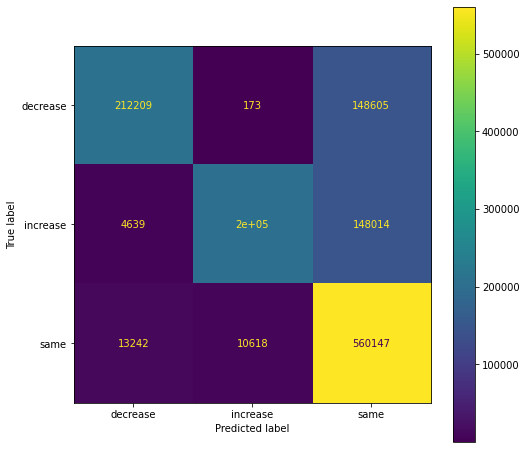

In [9]:
df1 = pd.read_csv('data/'+file_name+'_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_rf = joblib.load('data/model/model_rf.pkl') 
predictions = clf_rf.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

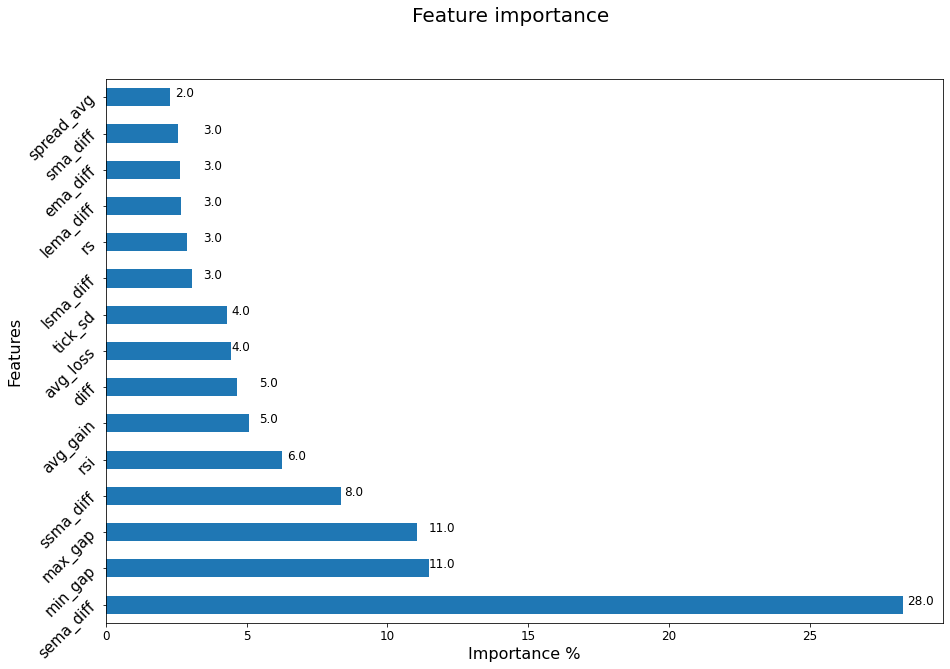

In [10]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf_rf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_rf.predict(x_scaled)

rounded_predictions = np.argmax(predictions, axis = -1)

live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

In [11]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)